# Analiza wydajności metod mnożenia macierzy

1. Naiwna metoda (potrójne pętle w naturalnej kolejności)
2. Ulepszona metoda (ze zamienioną kolejnością pętli)
3. Implementacja z użyciem BLAS (poprzez GSL)

In [21]:
using DataFrames
using CSV
using Plots
using Statistics

## Wczytanie danych z pliku CSV

Najpierw wczytamy dane wygenerowane przez program w C:

In [2]:
# Wczytanie danych
df_no_opt = CSV.read("results_no_opt.csv", DataFrame)
println("Dane bez optymalizacji:")
df_no_opt

Dane bez optymalizacji:


Row,Rozmiar,Naiwna,Ulepszona,BLAS
,Int64,Float64,Float64,Float64
1,100,0.003767,0.002119,0.00042
2,200,0.02783,0.015892,0.003175
3,300,0.093196,0.055949,0.010685
4,400,0.222499,0.130524,0.025379
5,500,0.439732,0.267648,0.064738
6,600,0.760169,0.478575,0.110445
7,700,1.30135,0.765503,0.156611
8,800,1.82946,1.59432,0.245967
9,900,2.6321,1.66288,0.393837


In [3]:
df_opt = CSV.read("results_opt.csv", DataFrame)
println("Dane z optymalizacją:")
df_opt

Dane z optymalizacją:


Row,Rozmiar,Naiwna,Ulepszona,BLAS
,Int64,Float64,Float64,Float64
1,100,0.000951,0.000492,0.000455
2,200,0.00732,0.003422,0.00362
3,300,0.026552,0.009516,0.00995
4,400,0.065702,0.026594,0.026249
5,500,0.134627,0.059845,0.059391
6,600,0.239504,0.111017,0.104934
7,700,0.389711,0.193764,0.170102
8,800,0.600157,0.889076,0.303193
9,900,0.879645,0.442465,0.368705


## Wizualizacja wyników bez optymalizacji kompilatora

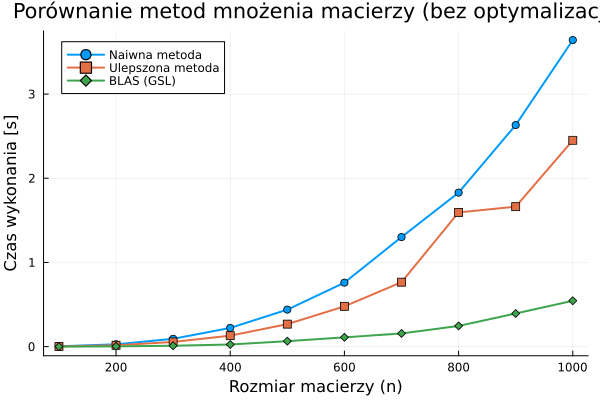

In [4]:
p1 = plot(df_no_opt.Rozmiar, df_no_opt.Naiwna, 
    label="Naiwna metoda", 
    xlabel="Rozmiar macierzy (n)", 
    ylabel="Czas wykonania [s]",
    title="Porównanie metod mnożenia macierzy (bez optymalizacji)",
    lw=2, marker=:circle, markersize=4)

plot!(p1, df_no_opt.Rozmiar, df_no_opt.Ulepszona, 
    label="Ulepszona metoda", 
    lw=2, marker=:square, markersize=4)

plot!(p1, df_no_opt.Rozmiar, df_no_opt.BLAS, 
    label="BLAS (GSL)", 
    lw=2, marker=:diamond, markersize=4)

display(p1)

## Analiza przyspieszenia względem naiwnej metody

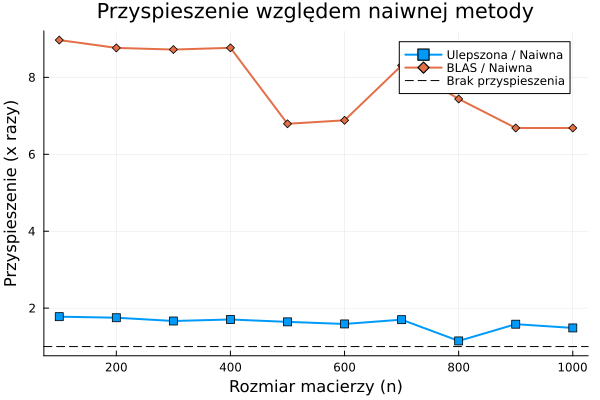

In [5]:
df_no_opt[!, :Przyspieszenie_Ulepszona] = df_no_opt.Naiwna ./ df_no_opt.Ulepszona
df_no_opt[!, :Przyspieszenie_BLAS] = df_no_opt.Naiwna ./ df_no_opt.BLAS

p2 = plot(df_no_opt.Rozmiar, df_no_opt.Przyspieszenie_Ulepszona, 
    label="Ulepszona / Naiwna", 
    xlabel="Rozmiar macierzy (n)", 
    ylabel="Przyspieszenie (x razy)",
    title="Przyspieszenie względem naiwnej metody",
    lw=2, marker=:square, markersize=4)

plot!(p2, df_no_opt.Rozmiar, df_no_opt.Przyspieszenie_BLAS, 
    label="BLAS / Naiwna", 
    lw=2, marker=:diamond, markersize=4)

hline!(p2, [1.0], label="Brak przyspieszenia", ls=:dash, color=:black)

display(p2)

## Aproksymacja wielomianowa



In [27]:
using Printf
using Polynomials
# Funkcja pomocnicza do dopasowania wielomianu stopnia 3
function fit_and_plot_polynomial(x, y, label_data, color, title_suffix="")
    # Dopasowanie wielomianu stopnia 3 (zgodnie z teoretyczną złożonością O(n³))
    poly_fit = fit(x, y, 3)
    
    # Współczynniki wielomianu
    coeffs = Polynomials.coeffs(poly_fit)
    
    # Przygotowanie równania wielomianu do wyświetlenia
    equation = @sprintf("%.2e·n³ + %.2e·n² + %.2e·n + %.2e", coeffs[4], coeffs[3], coeffs[2], coeffs[1])
    
    println("$label_data aproksymacja: $equation")
    
    # Generowanie punktów dla gładkiego wykresu wielomianu
    x_smooth = range(minimum(x), maximum(x), length=100)
    y_smooth = [poly_fit(xi) for xi in x_smooth]
    
    # Rysowanie wykresu
    plot(x_smooth, y_smooth, 
         label="Wielomian dla $label_data", 
         color=color, 
         linewidth=2, 
         linestyle=:dash,
         title="Aproksymacja wielomianowa $title_suffix")
    
    # Dodanie punktów danych
    scatter!(x, y, 
             label="Dane $label_data", 
             color=color, 
             markersize=5)
    
    return poly_fit
end

fit_and_plot_polynomial (generic function with 2 methods)

Naiwna aproksymacja: 3.55e-09·n³ + 1.67e-07·n² + -9.31e-05·n + 8.61e-03


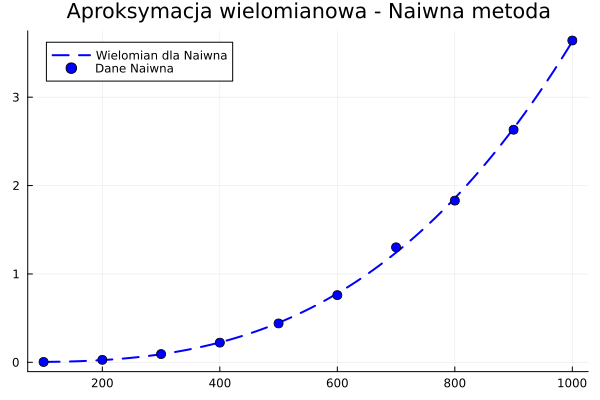

In [28]:
# Aproksymacja dla naiwnej metody
poly_naive = fit_and_plot_polynomial(
    df_no_opt.Rozmiar, 
    df_no_opt.Naiwna, 
    "Naiwna", 
    :blue,
    "- Naiwna metoda"
)

display(current())

Ulepszona aproksymacja: 7.25e-10·n³ + 2.88e-06·n² + -1.30e-03·n + 1.30e-01


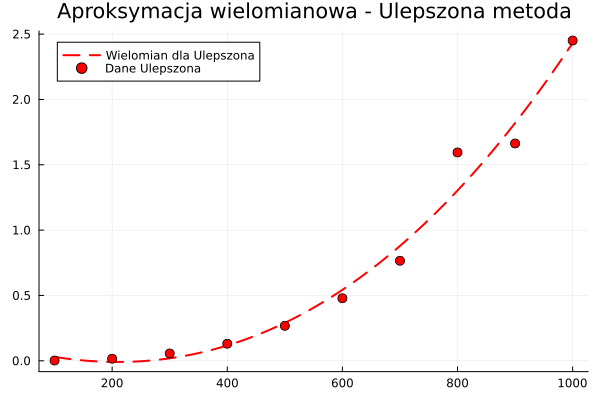

In [29]:
# Aproksymacja dla ulepszonej metody
poly_better = fit_and_plot_polynomial(
    df_no_opt.Rozmiar, 
    df_no_opt.Ulepszona, 
    "Ulepszona", 
    :red,
    "- Ulepszona metoda"
)

display(current())

BLAS aproksymacja: 8.84e-10·n³ + -4.87e-07·n² + 1.65e-04·n + -1.50e-02


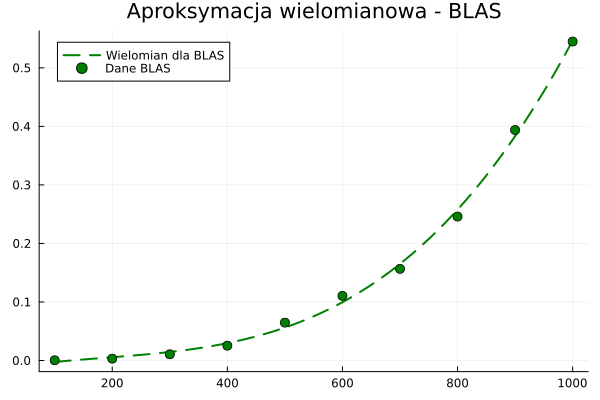

In [30]:
# Aproksymacja dla metody BLAS
poly_blas = fit_and_plot_polynomial(
    df_no_opt.Rozmiar, 
    df_no_opt.BLAS, 
    "BLAS", 
    :green,
    "- BLAS"
)

display(current())

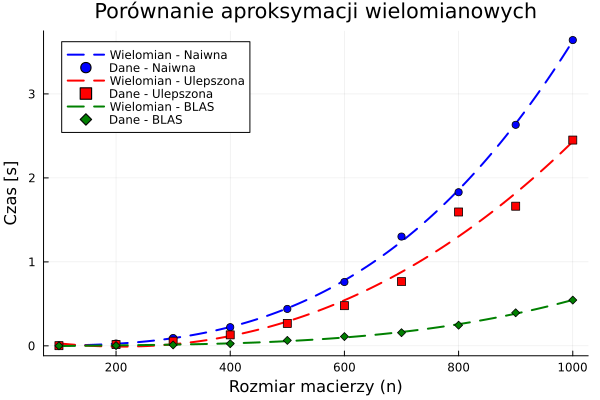

In [31]:
# Wykres zawierający wszystkie aproksymacje i dane dla lepszego porównania
p_all = plot(title="Porównanie aproksymacji wielomianowych", xlabel="Rozmiar macierzy (n)", ylabel="Czas [s]")

# Gładkie krzywe wielomianów
x_smooth = range(minimum(df_no_opt.Rozmiar), maximum(df_no_opt.Rozmiar), length=100)

# Naiwna metoda
plot!(p_all, x_smooth, [poly_naive(xi) for xi in x_smooth], 
    label="Wielomian - Naiwna", color=:blue, lw=2, ls=:dash)
scatter!(p_all, df_no_opt.Rozmiar, df_no_opt.Naiwna, 
    label="Dane - Naiwna", color=:blue, marker=:circle, markersize=4)

# Ulepszona metoda
plot!(p_all, x_smooth, [poly_better(xi) for xi in x_smooth], 
    label="Wielomian - Ulepszona", color=:red, lw=2, ls=:dash)
scatter!(p_all, df_no_opt.Rozmiar, df_no_opt.Ulepszona, 
    label="Dane - Ulepszona", color=:red, marker=:square, markersize=4)

# Metoda BLAS
plot!(p_all, x_smooth, [poly_blas(xi) for xi in x_smooth], 
    label="Wielomian - BLAS", color=:green, lw=2, ls=:dash)
scatter!(p_all, df_no_opt.Rozmiar, df_no_opt.BLAS, 
    label="Dane - BLAS", color=:green, marker=:diamond, markersize=4)

display(p_all)

## Analiza współczynników wielomianu

Teoretyczna złożoność mnożenia macierzy to O(n³).

In [32]:
# Pobranie współczynników wielomianów
coeffs_naive = Polynomials.coeffs(poly_naive)
coeffs_better = Polynomials.coeffs(poly_better)
coeffs_blas = Polynomials.coeffs(poly_blas)

# Współczynnik przy n³ (czwarty współczynnik, indeks 4)
n3_naive = coeffs_naive[4]
n3_better = coeffs_better[4]
n3_blas = coeffs_blas[4]

println("Współczynniki przy n³:")
println("Naiwna metoda: $(n3_naive)")
println("Ulepszona metoda: $(n3_better)")
println("BLAS: $(n3_blas)")
println()
println("Przyspieszenie względem naiwnej metody (na podstawie współczynnika):")
println("Ulepszona / Naiwna: $(n3_naive / n3_better)")
println("BLAS / Naiwna: $(n3_naive / n3_blas)")

Współczynniki przy n³:
Naiwna metoda: 3.5481179098679124e-9
Ulepszona metoda: 7.248236208236228e-10
BLAS: 8.83583916083916e-10

Przyspieszenie względem naiwnej metody (na podstawie współczynnika):
Ulepszona / Naiwna: 4.895146636965498
BLAS / Naiwna: 4.015598117260137


## Zniwelowanie efektu Rungego z użyciem wielomianów Czebyszewa

Efekt Rungego to problem pojawiający się przy aproksymacji wielomianowej wysokiego stopnia, gdzie pojawiają się silne oscylacje na brzegach przedziału aproksymacji. Wielomiany Czebyszewa pomagają zniwelować ten efekt, zapewniając bardziej stabilną aproksymację.

In [38]:
using Polynomials
using Plots
using Printf

# Funkcja do dopasowania wielomianu Czebyszewa
function fit_and_plot_chebyshev(x, y, label_data, color, degree=3)
    # Normalizacja x do przedziału [-1, 1], który jest domeną wielomianów Czebyszewa
    x_min, x_max = extrema(x)
    x_normalized = 2.0 * (x .- x_min) / (x_max - x_min) .- 1.0
    
    # Dopasowanie wielomianu Czebyszewa
    cheby_fit = fit(ChebyshevT, x_normalized, y, degree)
    
    # Konwersja do standardowego wielomianu do wyświetlenia
    poly_equivalent = convert(Polynomial, cheby_fit)
    coeffs_poly = coeffs(poly_equivalent)
    
    # Przygotowanie równania wielomianu do wyświetlenia
    if length(coeffs_poly) >= 4
        equation = @sprintf("%.2e·n³ + %.2e·n² + %.2e·n + %.2e", 
                              coeffs_poly[4], coeffs_poly[3], coeffs_poly[2], coeffs_poly[1])
    else
        equation = "Brak wystarczających współczynników"
    end
    
    println("$label_data aproksymacja Czebyszewa: $equation")
    
    # Generowanie punktów dla gładkiego wykresu wielomianu
    x_smooth_norm = range(-1, 1, length=100)
    x_smooth = (x_smooth_norm .+ 1) .* (x_max - x_min) / 2.0 .+ x_min
    y_smooth = [cheby_fit(xi) for xi in x_smooth_norm]
    
    # Rysowanie wykresu
    plot(x_smooth, y_smooth, 
         label="Czebyszew dla $label_data", 
         color=color, 
         linewidth=2, 
         linestyle=:dash,
         title="Aproksymacja wielomianami Czebyszewa",
         xlabel="Rozmiar macierzy (n)",
         ylabel="Czas [s]")
    
    # Dodanie punktów danych
    scatter!(x, y, 
             label="Dane $label_data", 
             color=color, 
             markersize=5)
    
    return cheby_fit, poly_equivalent
end


fit_and_plot_chebyshev (generic function with 2 methods)

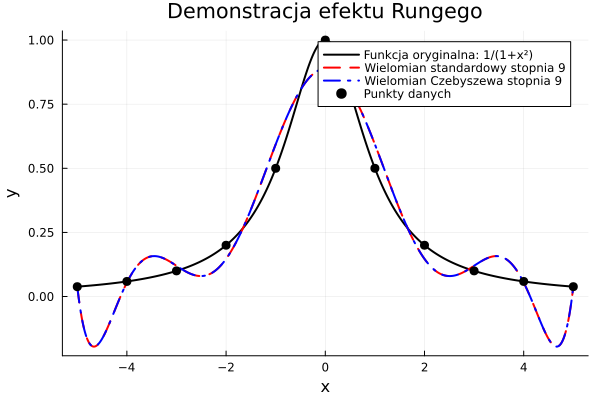

In [39]:
# Demonstracja efektu Rungego z wykorzystaniem standardowej aproksymacji wielomianowej wysokiego stopnia
# Utworzenie danych do prezentacji efektu
x_runge = range(-5, 5, length=11)
y_runge = 1.0 ./ (1.0 .+ x_runge.^2)  # Funkcja Rungego

# Dopasowanie standardowego wielomianu wysokiego stopnia (9)
runge_poly = fit(x_runge, y_runge, 9)

# Dopasowanie wielomianu Czebyszewa tego samego stopnia
x_runge_norm = 2.0 * (x_runge .- minimum(x_runge)) / (maximum(x_runge) - minimum(x_runge)) .- 1.0
runge_cheby = fit(ChebyshevT, x_runge_norm, y_runge, 9)

# Punkty do rysowania gładkich krzywych
x_smooth = range(minimum(x_runge), maximum(x_runge), length=1000)
x_smooth_norm = 2.0 * (x_smooth .- minimum(x_runge)) / (maximum(x_runge) - minimum(x_runge)) .- 1.0

# Wartości funkcji Rungego dla gładkiej krzywej
y_runge_smooth = 1.0 ./ (1.0 .+ x_smooth.^2)

# Wartości z aproksymacji wielomianowej
y_poly_smooth = [runge_poly(x) for x in x_smooth]

# Wartości z aproksymacji wielomianami Czebyszewa
y_cheby_smooth = [runge_cheby(x) for x in x_smooth_norm]

# Rysowanie wykresu porównawczego
p_runge = plot(x_smooth, y_runge_smooth, 
          label="Funkcja oryginalna: 1/(1+x²)", 
          color=:black, 
          linewidth=2,
          title="Demonstracja efektu Rungego",
          xlabel="x",
          ylabel="y")

plot!(p_runge, x_smooth, y_poly_smooth, 
    label="Wielomian standardowy stopnia 9", 
    color=:red, 
    linewidth=2, 
    linestyle=:dash)

plot!(p_runge, x_smooth, y_cheby_smooth, 
    label="Wielomian Czebyszewa stopnia 9", 
    color=:blue, 
    linewidth=2, 
    linestyle=:dashdot)

scatter!(p_runge, x_runge, y_runge, 
      label="Punkty danych", 
      color=:black, 
      markersize=5)

display(p_runge)

Na powyższym wykresie widać wyraźnie efekt Rungego: standardowy wielomian stopnia 9 bardzo dobrze dopasowuje się do punktów danych, ale pomiędzy nimi występują silne oscylacje, szczególnie na brzegach. Wielomian Czebyszewa tego samego stopnia znacząco redukuje te oscylacje, zapewniając bardziej stabilną aproksymację.

Teraz zastosujmy wielomiany Czebyszewa do naszych danych dotyczących mnożenia macierzy:

Naiwna aproksymacja Czebyszewa: 3.23e-01·n³ + 1.22e+00·n² + 1.49e+00·n + 5.98e-01


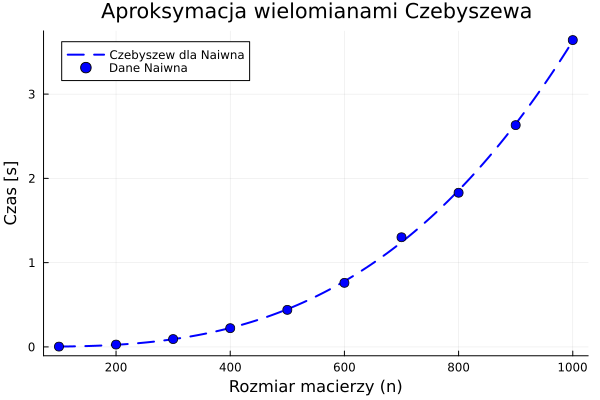

In [40]:
# Aproksymacja dla naiwnej metody z wykorzystaniem wielomianów Czebyszewa
cheby_naive, poly_naive_from_cheby = fit_and_plot_chebyshev(
    df_no_opt.Rozmiar, 
    df_no_opt.Naiwna, 
    "Naiwna", 
    :blue,
    3  # Stopień wielomianu
)

display(current())

Ulepszona aproksymacja Czebyszewa: 6.60e-02·n³ + 8.25e-01·n² + 1.14e+00·n + 4.06e-01


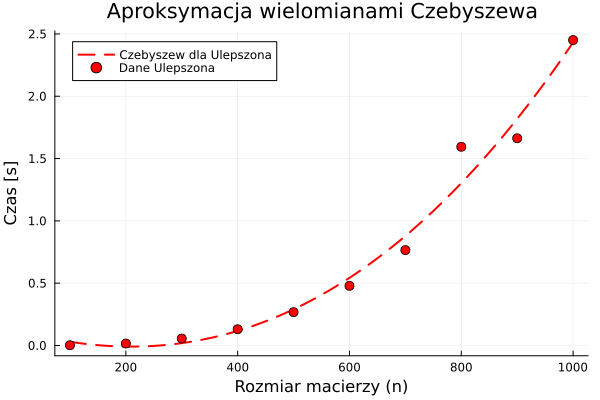

In [41]:
# Aproksymacja dla ulepszonej metody z wykorzystaniem wielomianów Czebyszewa
cheby_better, poly_better_from_cheby = fit_and_plot_chebyshev(
    df_no_opt.Rozmiar, 
    df_no_opt.Ulepszona, 
    "Ulepszona", 
    :red,
    3  # Stopień wielomianu
)

display(current())

BLAS aproksymacja Czebyszewa: 8.05e-02·n³ + 1.97e-01·n² + 1.94e-01·n + 7.55e-02


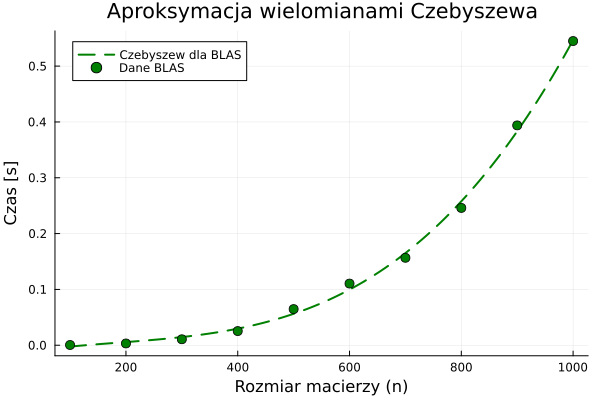

In [42]:
# Aproksymacja dla metody BLAS z wykorzystaniem wielomianów Czebyszewa
cheby_blas, poly_blas_from_cheby = fit_and_plot_chebyshev(
    df_no_opt.Rozmiar, 
    df_no_opt.BLAS, 
    "BLAS", 
    :green,
    3  # Stopień wielomianu
)

display(current())

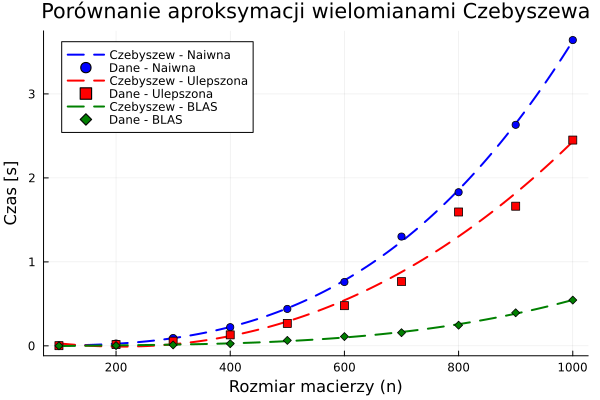

In [43]:
# Zbiorczy wykres wszystkich aproksymacji z wielomianami Czebyszewa
p_all_cheby = plot(title="Porównanie aproksymacji wielomianami Czebyszewa", 
                   xlabel="Rozmiar macierzy (n)", 
                   ylabel="Czas [s]")

# Punkty do gładkich krzywych
x_min = minimum(df_no_opt.Rozmiar)
x_max = maximum(df_no_opt.Rozmiar)
x_smooth = range(x_min, x_max, length=100)
x_smooth_norm = 2.0 * (x_smooth .- x_min) / (x_max - x_min) .- 1.0

# Naiwna metoda
y_naive_cheby = [cheby_naive(x) for x in x_smooth_norm]
plot!(p_all_cheby, x_smooth, y_naive_cheby, 
    label="Czebyszew - Naiwna", color=:blue, lw=2, ls=:dash)
scatter!(p_all_cheby, df_no_opt.Rozmiar, df_no_opt.Naiwna, 
    label="Dane - Naiwna", color=:blue, marker=:circle, markersize=4)

# Ulepszona metoda
y_better_cheby = [cheby_better(x) for x in x_smooth_norm]
plot!(p_all_cheby, x_smooth, y_better_cheby, 
    label="Czebyszew - Ulepszona", color=:red, lw=2, ls=:dash)
scatter!(p_all_cheby, df_no_opt.Rozmiar, df_no_opt.Ulepszona, 
    label="Dane - Ulepszona", color=:red, marker=:square, markersize=4)

# Metoda BLAS
y_blas_cheby = [cheby_blas(x) for x in x_smooth_norm]
plot!(p_all_cheby, x_smooth, y_blas_cheby, 
    label="Czebyszew - BLAS", color=:green, lw=2, ls=:dash)
scatter!(p_all_cheby, df_no_opt.Rozmiar, df_no_opt.BLAS, 
    label="Dane - BLAS", color=:green, marker=:diamond, markersize=4)

display(p_all_cheby)

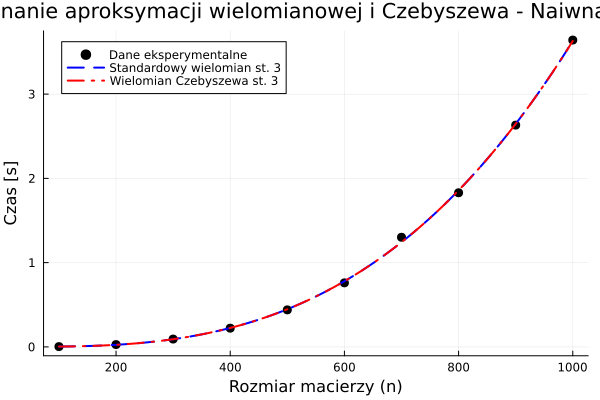

In [44]:
# Porównanie standardowych wielomianów z wielomianami Czebyszewa dla naiwnej metody
p_comparison = plot(title="Porównanie aproksymacji wielomianowej i Czebyszewa - Naiwna metoda", 
                   xlabel="Rozmiar macierzy (n)", 
                   ylabel="Czas [s]")

# Dane eksperymentalne
scatter!(p_comparison, df_no_opt.Rozmiar, df_no_opt.Naiwna, 
    label="Dane eksperymentalne", color=:black, marker=:circle, markersize=5)

# Standardowy wielomian
y_naive_poly = [poly_naive(xi) for xi in x_smooth]
plot!(p_comparison, x_smooth, y_naive_poly, 
    label="Standardowy wielomian st. 3", color=:blue, lw=2, ls=:dash)

# Wielomian Czebyszewa
plot!(p_comparison, x_smooth, y_naive_cheby, 
    label="Wielomian Czebyszewa st. 3", color=:red, lw=2, ls=:dashdot)

display(p_comparison)

## Porównanie wielomianów standardowych i Czebyszewa

Porównajmy współczynniki wielomianów standardowych i Czebyszewa:

In [45]:
# Pobranie współczynników wielomianów
coeffs_naive_standard = Polynomials.coeffs(poly_naive)
coeffs_better_standard = Polynomials.coeffs(poly_better)
coeffs_blas_standard = Polynomials.coeffs(poly_blas)

coeffs_naive_cheby = Polynomials.coeffs(poly_naive_from_cheby)
coeffs_better_cheby = Polynomials.coeffs(poly_better_from_cheby)
coeffs_blas_cheby = Polynomials.coeffs(poly_blas_from_cheby)

println("Współczynniki wielomianów standardowych:")
println("Naiwna metoda: $(round.(coeffs_naive_standard, digits=10))")
println("Ulepszona metoda: $(round.(coeffs_better_standard, digits=10))")
println("BLAS: $(round.(coeffs_blas_standard, digits=10))")
println()
println("Współczynniki wielomianów z Czebyszewa:")
println("Naiwna metoda: $(round.(coeffs_naive_cheby, digits=10))")
println("Ulepszona metoda: $(round.(coeffs_better_cheby, digits=10))")
println("BLAS: $(round.(coeffs_blas_cheby, digits=10))")

Współczynniki wielomianów standardowych:
Naiwna metoda: [0.0086059333, -9.31034e-5, 1.674e-7, 3.5e-9]
Ulepszona metoda: [0.1304129333, -0.0012997073, 2.8769e-6, 7.0e-10]
BLAS: [-0.0149959333, 0.0001652515, -4.872e-7, 9.0e-10]

Współczynniki wielomianów z Czebyszewa:
Naiwna metoda: [0.5983595063, 1.4899353813, 1.2194159574, 0.3233222445]
Ulepszona metoda: [0.406420475, 1.1351836119, 0.8247484432, 0.0660495524]
BLAS: [0.0755319625, 0.1940512303, 0.1965770284, 0.0805165844]


## Wnioski dotyczące wielomianów Czebyszewa

Wielomiany Czebyszewa pomagają zniwelować efekt Rungego, który może pojawić się przy aproksymacji wielomianowej. Chociaż dla naszych danych dotyczących mnożenia macierzy efekt ten nie jest tak wyraźny (ze względu na niski stopień wielomianu i rozkład punktów pomiarowych), to zastosowanie wielomianów Czebyszewa może dostarczyć bardziej stabilnej aproksymacji, szczególnie w przypadku większej liczby punktów pomiarowych lub dla wyższych stopni wielomianu.

Warto zauważyć, że wielomiany Czebyszewa są szczególnie przydatne, gdy:
1. Aproksymujemy funkcje wielomianami wysokiego stopnia
2. Punkty danych są nierównomiernie rozmieszczone
3. Szczególnie zależy nam na dokładności aproksymacji na brzegach przedziału

W przypadku naszych danych dotyczących mnożenia macierzy, zarówno standardowe wielomiany jak i wielomiany Czebyszewa dają podobne wyniki, ale w ogólności wielomiany Czebyszewa oferują lepszą stabilność numeryczną i dokładniejszą aproksymację.

## Porównanie z optymalizacją kompilatora (dla chętnych)

Odkomentuj poniższy kod, jeśli masz dane z optymalizacją kompilatora:

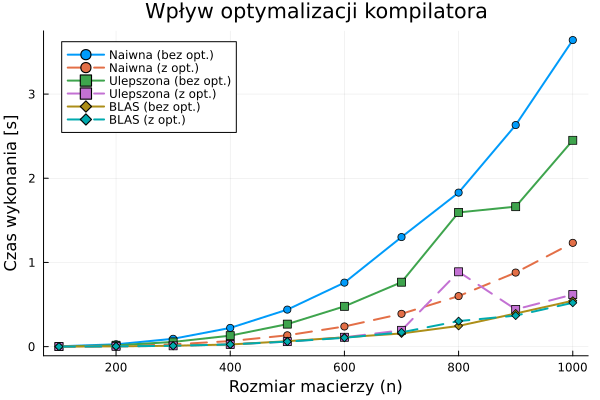

In [46]:
p3 = plot(title="Wpływ optymalizacji kompilatora", xlabel="Rozmiar macierzy (n)", ylabel="Czas wykonania [s]")

# Naiwna metoda
plot!(p3, df_no_opt.Rozmiar, df_no_opt.Naiwna, label="Naiwna (bez opt.)", lw=2, marker=:circle, markersize=4)
plot!(p3, df_opt.Rozmiar, df_opt.Naiwna, label="Naiwna (z opt.)", lw=2, ls=:dash, marker=:circle, markersize=4)

# Ulepszona metoda
plot!(p3, df_no_opt.Rozmiar, df_no_opt.Ulepszona, label="Ulepszona (bez opt.)", lw=2, marker=:square, markersize=4)
plot!(p3, df_opt.Rozmiar, df_opt.Ulepszona, label="Ulepszona (z opt.)", lw=2, ls=:dash, marker=:square, markersize=4)

# BLAS
plot!(p3, df_no_opt.Rozmiar, df_no_opt.BLAS, label="BLAS (bez opt.)", lw=2, marker=:diamond, markersize=4)
plot!(p3, df_opt.Rozmiar, df_opt.BLAS, label="BLAS (z opt.)", lw=2, ls=:dash, marker=:diamond, markersize=4)

display(p3)

## Wnioski

Na podstawie przedstawionych wyników możemy wyciągnąć następujące wnioski:

1. **Naiwna metoda** - standardowa implementacja z potrójną pętlą jest najwolniejsza ze wszystkich metod. Wynika to z faktu, że wzorzec dostępu do pamięci nie jest optymalny dla układu danych w języku C (row-major order).

2. **Ulepszona metoda** - zmiana kolejności pętli pozwala na lepsze wykorzystanie lokalności danych, co prowadzi do znacznej poprawy wydajności. Zysk jest szczególnie widoczny dla większych macierzy.

3. **Metoda BLAS** - wykorzystanie zoptymalizowanej biblioteki BLAS przez GSL daje najlepsze wyniki. Biblioteki BLAS są zoptymalizowane pod kątem konkretnej architektury procesora i wykorzystują zaawansowane techniki optymalizacji, takie jak rozwijanie pętli, wektoryzacja, równoległość na poziomie instrukcji, itp.

Ponadto, włączenie optymalizacji kompilatora ma znaczący wpływ na wydajność wszystkich implementacji, ale największy zysk widoczny jest w przypadku naiwnej i ulepszonej metody. Biblioteka BLAS jest już zoptymalizowana na poziomie implementacji, więc korzyści z optymalizacji kompilatora są mniejsze.